<h1>Phase 4 Final Project Submission</h1>

<h3>Student Name: Jason Lombino</h3>
<hr>

<h1>Business Problem</h1>

<h1>Libraries</h1>

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from skimage.segmentation import mark_boundaries
from lime import lime_image
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import preprocessing
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import applications
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

<h1>Data

In [2]:
train_path = 'chest_xray/train'
test_path = 'chest_xray/test'
val_path = 'chest_xray/val'

In [3]:
train_generator = preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=45,
    zoom_range=0.3
)

train_ds = train_generator.flow_from_directory(
    train_path,
    target_size=(256,256),
    class_mode='binary',
)

Found 4175 images belonging to 2 classes.


In [4]:
val_generator = preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

val_ds = val_generator.flow_from_directory(
    val_path,
    target_size=(256,256),
    class_mode='binary',
    shuffle=False
)

Found 1057 images belonging to 2 classes.


In [5]:
test_generator = preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_ds = test_generator.flow_from_directory(
    test_path,
    target_size=(256,256),
    class_mode='binary',
    shuffle=False
)

Found 624 images belonging to 2 classes.


<h1>Data Visualizations

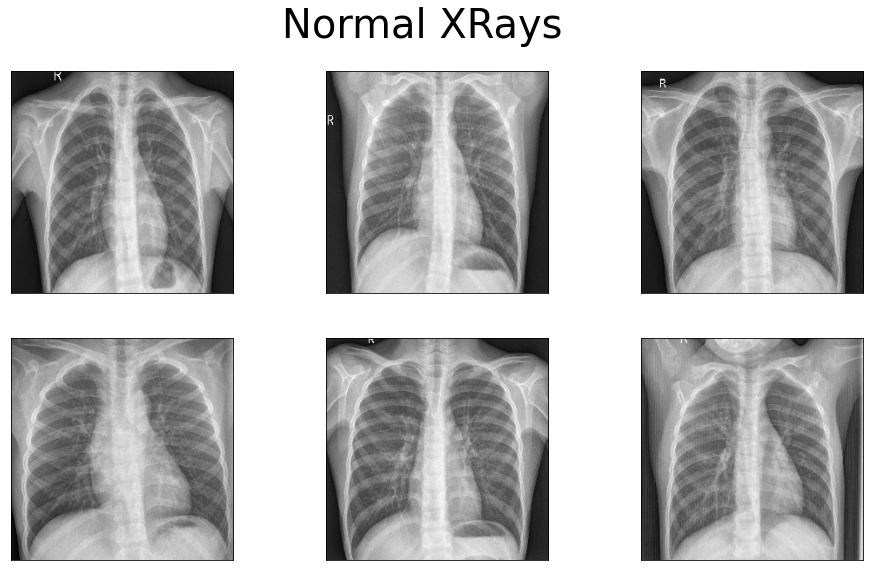

In [6]:
normal_images = []
for image in test_ds[0][0][:6]:
    normal_images.append(image)

normal_fig,normal_ax = plt.subplots(2,3,figsize=(16,9))
for idx,image in enumerate(normal_images[:6]):
        active_axis = normal_ax[idx//3][idx%3]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
normal_fig.set_facecolor('#FFFFFF')
normal_fig.suptitle('Normal XRays', fontsize=40);

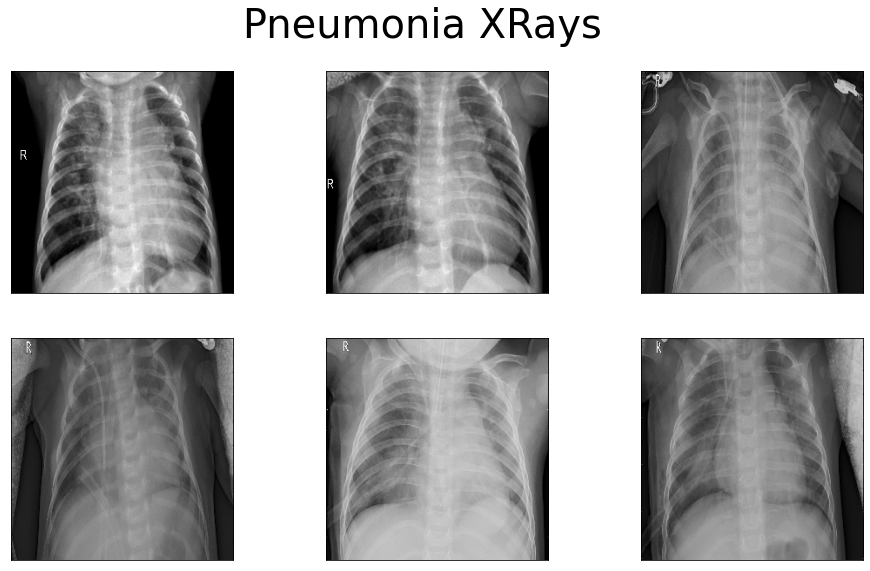

In [7]:
sick_images = []
for image in test_ds[len(test_ds)-1][0][:6]:
    sick_images.append(image)

sick_fig,sick_ax = plt.subplots(2,3,figsize=(16,9))
for idx,image in enumerate(sick_images[:6]):
        active_axis = sick_ax[idx//3][idx%3]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
sick_fig.set_facecolor('#FFFFFF')
sick_fig.suptitle('Pneumonia XRays', fontsize=40);

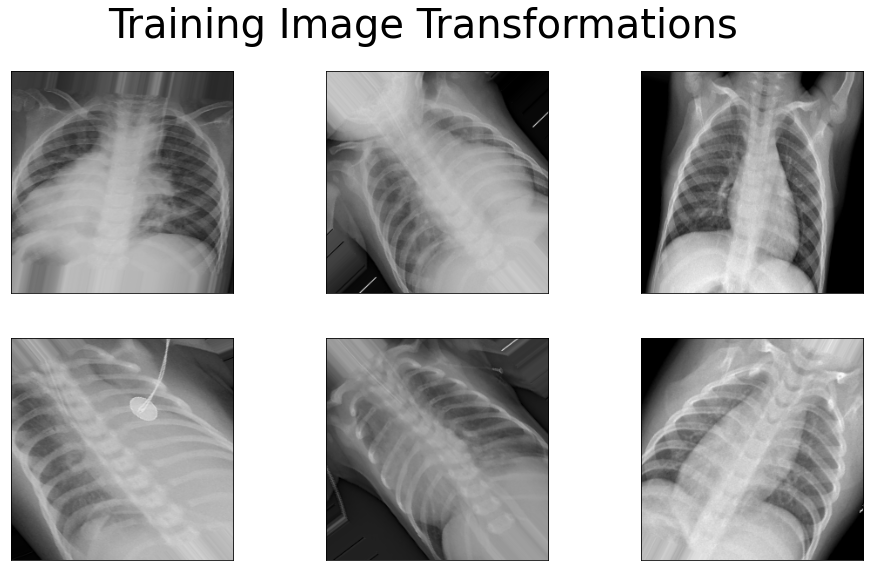

In [8]:
train_prep = train_ds[0][0][:6]

train_fig,train_ax = plt.subplots(2,3,figsize=(16,9))
for idx,image in enumerate(train_prep[:6]):
        active_axis = train_ax[idx//3][idx%3]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
train_fig.set_facecolor('#FFFFFF')
train_fig.suptitle('Training Image Transformations', fontsize=40);

<h1>Modeling</h1>

Various models results

| Model Name                                     | % Train Accuracy | % Val Accuracy | 
|------------------------------------------------|------------------|----------------|
| * Basic CNN                                      | 98.8             | 96.7           | 
| Basic CNN Image Preprocessing                  | 93.5             | 91.2           | 
| Larger CNN                                     | 93.5             | 94.0           | 
| Larger CNN tanh Activation                     | 74.3             | 74.1           | 
| Larger CNN Dropout                             | 93.3             | 94.0           | 
| Larger CNN Larger Stride                       | 95.3             | 93.4           | 
| Larger CNN Double Convolutional Layers         | 95.5             | 94.0           | 
| Even Larger CNN                                | 94.8             | 94.5           | 
| Transfer Learning Xception                     | 96.6             | 94.0           | 
| Transfer Learning VGG16                        | 95.0             | 95.7           | 
| Transfer Learning VGG16 Decaying Learning Rate | 94.7             | 94.2           |

<h1>Second Best Model (Even Larger CNN)</h1>

In [9]:
nt_model = models.Sequential()

nt_model.add(layers.Conv2D(32, (1, 1), activation='relu',padding='same',
                        input_shape=(256, 256, 3)))     
nt_model.add(layers.Conv2D(32, (1, 1), activation='relu',padding='same'))                
nt_model.add(layers.MaxPooling2D((2, 2)))

nt_model.add(layers.Conv2D(64, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.Conv2D(64, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.MaxPooling2D((2, 2)))

nt_model.add(layers.Conv2D(128, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.Conv2D(128, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.MaxPooling2D((2, 2)))

nt_model.add(layers.Conv2D(256, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.Conv2D(256, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.MaxPooling2D((2, 2)))

nt_model.add(layers.Flatten())
nt_model.add(layers.Dense(512, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(512, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(256, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(128, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(64, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(32, activation='relu'))
nt_model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
nt_checkpoint = callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath='save_data/nt_model.hdf5',
    save_best_only=True,
    verbose=0
)

nt_callbacks = [nt_checkpoint]

use_metrics = [metrics.BinaryAccuracy(),\
                metrics.Precision(),\
                metrics.Recall()]

In [11]:
nt_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=[use_metrics]
)

print(nt_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      1056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      2112      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      4160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       8

In [13]:
nt_history = nt_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=nt_callbacks
)

nt_model.load_weights('save_data/nt_model.hdf5')

Epoch 1/5
131/131 [==============================] - 109s 830ms/step - loss: 0.5387 - binary_accuracy: 0.7368 - precision: 0.7425 - recall: 0.9881 - val_loss: 0.5115 - val_binary_accuracy: 0.6272 - val_precision: 0.9492 - val_recall: 0.5249
Epoch 2/5
131/131 [==============================] - 106s 807ms/step - loss: 0.3844 - binary_accuracy: 0.8165 - precision: 0.8539 - recall: 0.9084 - val_loss: 0.3044 - val_binary_accuracy: 0.8666 - val_precision: 0.9105 - val_recall: 0.9093
Epoch 3/5
131/131 [==============================] - 107s 815ms/step - loss: 0.2758 - binary_accuracy: 0.8829 - precision: 0.9172 - recall: 0.9258 - val_loss: 0.2179 - val_binary_accuracy: 0.8903 - val_precision: 0.8994 - val_recall: 0.9591
Epoch 4/5
131/131 [==============================] - 106s 811ms/step - loss: 0.2581 - binary_accuracy: 0.9054 - precision: 0.9347 - recall: 0.9381 - val_loss: 0.1799 - val_binary_accuracy: 0.9167 - val_precision: 0.9317 - val_recall: 0.9579
Epoch 5/5
131/131 [=================

No handles with labels found to put in legend.


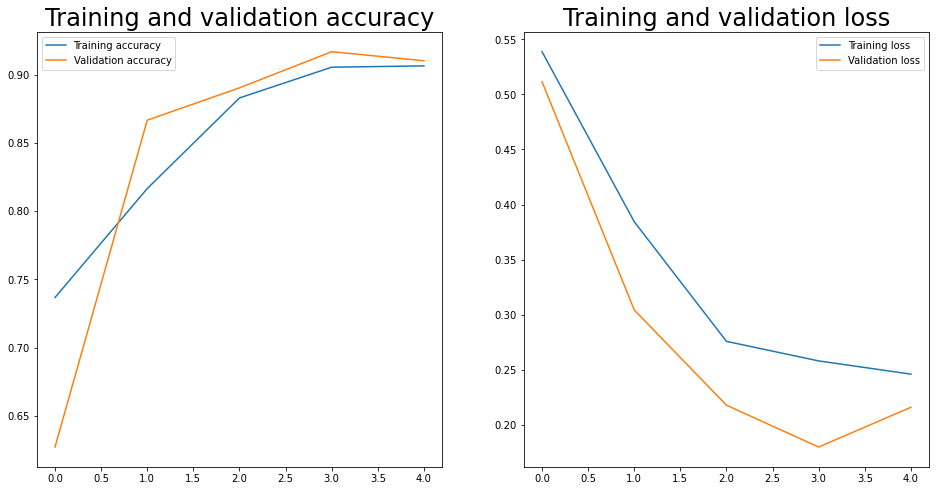

In [18]:
nt_acc = nt_history.history['binary_accuracy']
nt_val_acc = nt_history.history['val_binary_accuracy']
nt_loss = nt_history.history['loss']
nt_val_loss = nt_history.history['val_loss']
nt_epochs = range(len(nt_acc))

nt_fig,nt_ax = plt.subplots(1,2,figsize=(16,8))
nt_ax[0].plot(nt_epochs, nt_acc, label='Training accuracy');
nt_ax[0].plot(nt_epochs, nt_val_acc, label='Validation accuracy');
nt_ax[0].set_title('Training and validation accuracy',fontsize=24);
nt_ax[1].legend();
nt_ax[0].legend();

nt_ax[1].plot(nt_epochs, nt_loss, label='Training loss');
nt_ax[1].plot(nt_epochs, nt_val_loss, label='Validation loss');
nt_ax[1].set_title('Training and validation loss',fontsize=24);
nt_ax[1].legend();

In [ ]:
nt_train_results = nt_model.evaluate(train_ds)

In [ ]:
nt_val_res = nt_model.evaluate(val_ds)

In [22]:
nt_test_res = nt_model.evaluate(test_ds)

20/20 [==============================] - 4s 207ms/step - loss: 0.4535 - binary_accuracy: 0.8462 - precision: 0.8050 - recall: 0.9949


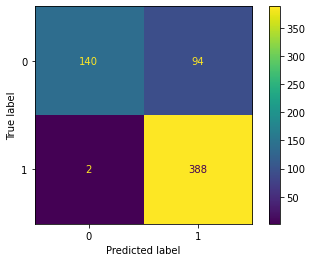

In [21]:
nt_test_predictions = nt_model.predict_classes(test_ds)
test_actual = test_ds.labels
nt_c_matrix = confusion_matrix(test_actual,nt_test_predictions)
ConfusionMatrixDisplay(nt_c_matrix).plot()

<h1>Best Model (Transfer Learning with VGG16)

In [25]:
vgg_base = applications.VGG16(
    weights='imagenet',
    input_shape=(256, 256, 3),
    include_top=False
)

vgg_base.trainable = False

In [26]:
tx_model = models.Sequential()

tx_model.add(vgg_base)                   
tx_model.add(layers.Flatten())
tx_model.add(layers.Dense(512, activation='relu'))
tx_model.add(layers.Dense(256, activation='relu'))
tx_model.add(layers.Dense(128, activation='relu'))
tx_model.add(layers.Dense(64, activation='relu'))
tx_model.add(layers.Dense(1, activation='sigmoid'))

for layer in tx_model.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten_1 True
dense_7 True
dense_8 True
dense_9 True
dense_10 True
dense_11 True


In [ ]:
tx_checkpoint = callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath='save_data/tx_model.hdf5',
    save_best_only=True,
    verbose=0
)

tx_callbacks = [tx_checkpoint]

use_metrics = [metrics.BinaryAccuracy(),\
                metrics.Precision(),\
                metrics.Recall()]

In [ ]:
scheduler = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_rate=0.96,
    decay_steps=2500
)

In [ ]:
tx_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=scheduler),
    metrics=[use_metrics]
)

print(tx_model.summary())

In [ ]:
tx_history = tx_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks
)

tx_model = models.load_model('save_data/tx_model.hdf5')

In [ ]:
tx_acc = tx_history.history['binary_accuracy']
tx_val_acc = tx_history.history['val_binary_accuracy']
tx_loss = tx_history.history['loss']
tx_val_loss = tx_history.history['val_loss']
tx_epochs = range(len(tx_acc))

tx_fig,tx_ax = plt.subplots(1,2,figsize=(16,8))
tx_ax[0].plot(tx_epochs, tx_acc, label='Training accuracy');
tx_ax[0].plot(tx_epochs, tx_val_acc, label='Validation accuracy');
tx_ax[0].set_title('Training and validation accuracy',fontsize=24);
tx_ax[1].legend();
tx_ax[0].legend();

tx_ax[1].plot(tx_epochs, tx_loss, label='Training loss');
tx_ax[1].plot(tx_epochs, tx_val_loss, label='Validation loss');
tx_ax[1].set_title('Training and validation loss',fontsize=24);
tx_ax[1].legend();

In [ ]:
tx_train_res = tx_model.evaluate(train_ds)

In [ ]:
tx_val_res = tx_model.evaluate(val_ds)

In [ ]:
tx_test_res = tx_model.evaluate(test_ds)

In [ ]:
tx_test_predictions = tx_model.predict_classes(test_ds)
test_actual = test_ds.labels
tx_c_matrix = confusion_matrix(test_actual,tx_test_predictions)
ConfusionMatrixDisplay(tx_c_matrix).plot()

<h1>Analysis of Results</h1>

In [54]:
explainer = lime_image.LimeImageExplainer()

<h1>True Positives

In [57]:
true_pos = []

for batch in range(len(test_ds)):
    for idx,image in enumerate(test_ds[batch][0]):
        if len(true_pos) >= 6:
            break
        else:
            if nt_model.predict_classes(np.expand_dims(image,axis=0)) == 1 \
                and test_ds[batch][1][idx] == 1:
                true_pos.append(image)
    if len(true_pos) >= 6:
            break

100%|██████████| 1000/1000 [00:08<00:00, 122.87it/s]


Text(0.5, 0.98, 'True Positives Explained')

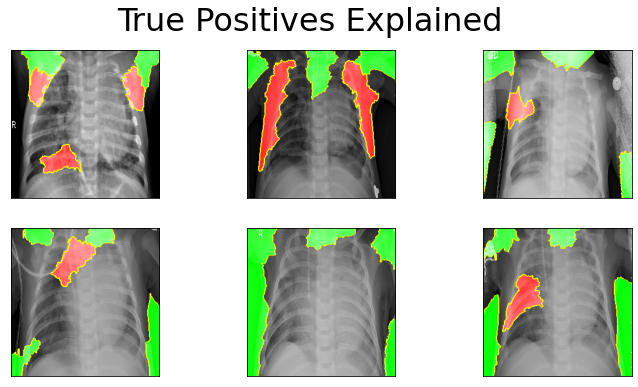

In [59]:
tp_fig, tp_ax = plt.subplots(2,3,figsize=(12,6))
for idx,image in enumerate(true_pos):
    active_axis = tp_ax[idx//3][idx%3]
    active_axis.set_xticks([])
    active_axis.set_yticks([])
    explanation = explainer.explain_instance(
        image, nt_model.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=5, hide_rest=False)
    active_axis.imshow(mark_boundaries(temp, mask))
    active_axis.text
tp_fig.set_facecolor('#FFFFFF')
tp_fig.suptitle('True Positives Explained',fontsize=32);

<h1>True Negatives

In [61]:
true_neg = []

for batch in range(len(test_ds)):
    for idx,image in enumerate(test_ds[batch][0]):
        if len(true_neg) >= 6:
            break
        else:
            if nt_model.predict_classes(np.expand_dims(image,axis=0)) == 0 \
                and test_ds[batch][1][idx] == 0:
                true_neg.append(image)
    if len(true_neg) >= 6:
            break

100%|██████████| 1000/1000 [00:07<00:00, 125.67it/s]


Text(0.5, 0.98, 'True Negatives Explained')

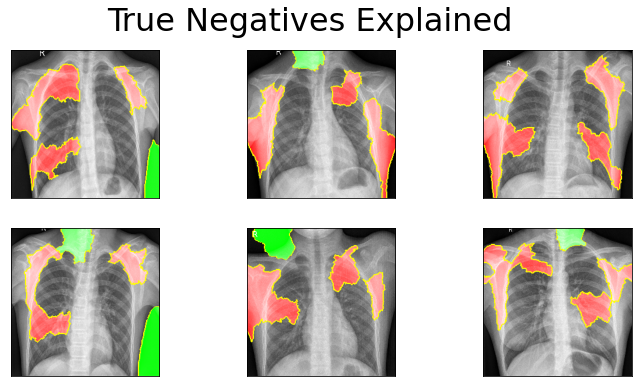

In [62]:
tn_fig, tn_ax = plt.subplots(2,3,figsize=(12,6))
for idx,image in enumerate(true_neg):
    active_axis = tn_ax[idx//3][idx%3]
    active_axis.set_xticks([])
    active_axis.set_yticks([])
    explanation = explainer.explain_instance(
        image, nt_model.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=5, hide_rest=False)
    active_axis.imshow(mark_boundaries(temp, mask))
    active_axis.text
tn_fig.set_facecolor('#FFFFFF')
tn_fig.suptitle('True Negatives Explained',fontsize=32);

<h1>Fasle Positives

In [63]:
false_pos = []

for batch in range(len(test_ds)):
    for idx,image in enumerate(test_ds[batch][0]):
        if len(false_pos) >= 6:
            break
        else:
            if nt_model.predict_classes(np.expand_dims(image,axis=0)) == 1 \
                and test_ds[batch][1][idx] == 0:
                false_pos.append(image)
    if len(false_pos) >= 6:
            break

100%|██████████| 1000/1000 [00:08<00:00, 122.68it/s]


Text(0.5, 0.98, 'False Positives Explained')

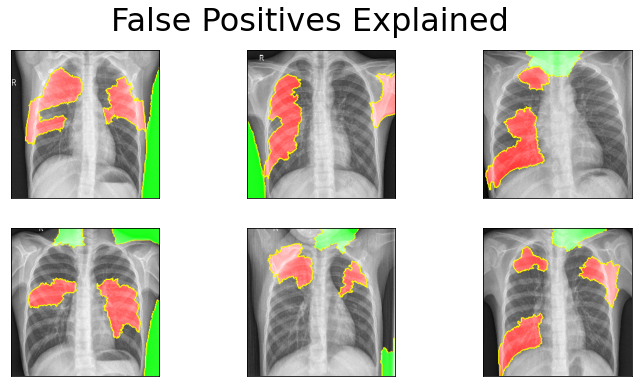

In [64]:
fp_fig, fp_ax = plt.subplots(2,3,figsize=(12,6))
for idx,image in enumerate(false_pos):
    active_axis = fp_ax[idx//3][idx%3]
    active_axis.set_xticks([])
    active_axis.set_yticks([])
    explanation = explainer.explain_instance(
        image, nt_model.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=5, hide_rest=False)
    active_axis.imshow(mark_boundaries(temp, mask))
    active_axis.text
fp_fig.set_facecolor('#FFFFFF')
fp_fig.suptitle('False Positives Explained',fontsize=32);

<h1>False Negatives

In [65]:
false_neg = []

for batch in range(len(test_ds)):
    for idx,image in enumerate(test_ds[batch][0]):
        if len(false_neg) >= 6:
            break
        else:
            if nt_model.predict_classes(np.expand_dims(image,axis=0)) == 0 \
                and test_ds[batch][1][idx] == 1:
                false_neg.append(image)
    if len(false_neg) >= 6:
            break

100%|██████████| 1000/1000 [00:08<00:00, 118.33it/s]


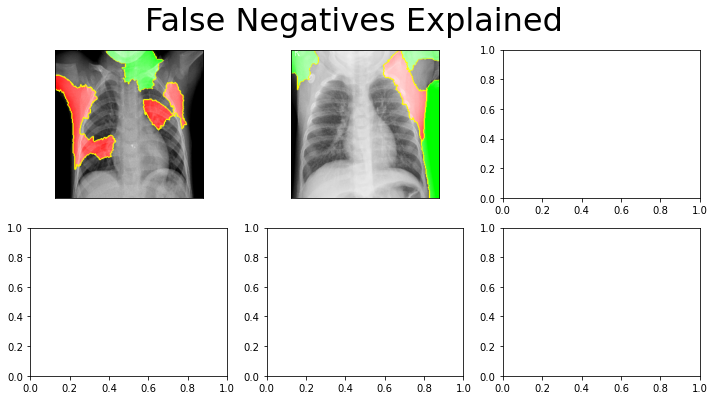

In [66]:
fn_fig, fn_ax = plt.subplots(2,3,figsize=(12,6))
for idx,image in enumerate(false_neg):
    active_axis = fn_ax[idx//3][idx%3]
    active_axis.set_xticks([])
    active_axis.set_yticks([])
    explanation = explainer.explain_instance(
        image, nt_model.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=5, hide_rest=False)
    active_axis.imshow(mark_boundaries(temp, mask))
    active_axis.text
fn_fig.set_facecolor('#FFFFFF')
fn_fig.suptitle('False Negatives Explained',fontsize=32);